In [220]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
from math import ceil, floor
from datetime import datetime 
torch.manual_seed(123)

import numpy as np
import random
from torchvision.utils import draw_bounding_boxes
import itertools

# Model definition

In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

class CNN_1(nn.Module):
    def __init__(self, in_channels = 1, out_channels = 15): #out_channel [p, x, y, w, h, c_0, ..., c_10] = 15
        super().__init__()
        # image dimension: 48x60

        self.conv1 = nn.Conv2d(in_channels, 4, kernel_size=3, stride=1, padding=1) #size: 48x60
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1) #size: 48x60
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2) #size: 24x30
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1) #size: 24x30
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) #size: 24x30
        # max_pool, size: 12x15
        self.conv5 = nn.Conv2d(32, 16, kernel_size=(3,2), stride=1, padding=1) #size: 12x16
        # max_pool, size: 6x8
        self.conv6 = nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1) #size: 6x8
        # max_pool, size: 3x4
        self.conv7 = nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1) #size: 3x4

        # fully connected layer at the end ?
        self.fc = nn.Linear(4*3*4, out_channels) #48x15

    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = self.max_pool(out)
        out = self.conv3(out)
        out = F.relu(out)
        out = self.conv4(out)
        out = F.relu(out)
        out = self.max_pool(out)
        out = self.conv5(out)
        out = F.relu(out)
        out = self.max_pool(out)
        out = self.conv6(out)
        out = F.relu(out)
        out = self.max_pool(out)
        out = self.conv7(out)
        out = F.relu(out)

        out = out.view(-1, out.shape[-3]*out.shape[-2]*out.shape[-1]) #flatten the dimensions to fit the fully connected layer
        out = self.fc(out)
        return out

Training on device cpu.


## Localization


In [ ]:
def localization_loss(y_pred, y_true):
    """
    Calculates the detection loss, localization loss and classification loss.
    Returns a total loss
    """
    # Detection loss
    L_A = nn.BCEWithLogitsLoss()
    # Bounding box loss (localization loss)
    L_B = nn.MSELoss()
    # Classification loss
    L_C = nn.CrossEntropyLoss()

    # er dette nødvendig egentlig ?? Se om crossentropy loss regnes riktig uten å endre på y_true
    # change format of y_true from [p, x, y, w, h, c] to [p, x, y, w, h, c_1, ..., c_10]
    #c = y_true[:, 5].long()  # get the class index
    #y_true_one_hot = torch.zeros(y_true.size(0), 10, device=y_true.device)  # create a zero tensor for one-hot encoding, device = device ?
    #y_true_one_hot.scatter_(1, c.unsqueeze(1), 1)  # set the corresponding class index to 1
    #y_true = torch.cat([y_true[:, :5], y_true_one_hot], dim=1)  # concatenate the one-hot encoded classes with the rest of y_true

    
    return torch.where(
        # if there is an object; calculate input
        condition=y_true[:, 0].bool(), 

        # L = L_A + L_B + L_C, when object is detected
        input= L_A(y_pred[:, :1], y_true[:, :1]) + 
        L_B(y_pred[:, 1:5], y_true[:, 1:5]) + 
        L_C(y_pred[:, 5:], y_true[:, 5].long()),

        # L = L_A, when object is not detected
        other= L_A(y_pred[:, :1], y_true[:, :1])
    ).mean()




### Load data and preprocessing

In [197]:
def load_data(path="data/localization_"):
    """
    Load data from path, return train, val, test
    """
    data_train = torch.load(path + "train.pt")
    data_val = torch.load(path + "val.pt")
    data_test = torch.load(path + "test.pt")


    return data_train, data_val, data_test


def data_distribution(data):
    """
    Plots the distribution of the given data across the labels with labels and counts.
    """
    
    labels = [label[5] for _, label in data]  # Assuming label[5] contains the class label
    
    # Calculate distribution using numpy
    unique_labels, counts = np.unique(labels, return_counts=True)
    distribution = dict(zip(unique_labels, counts))
    
    x_labels = [str(int(label)) for label in unique_labels]  # Convert to string for plotting
    
    # Visualize the label distribution using a bar chart
    plt.figure(figsize=(8, 5))
    bars = plt.bar(x_labels, counts, color='skyblue')
    
    # Add text on top of each bar to display count
    for bar, count, label in zip(bars, counts, x_labels):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                 f"{count}", ha='center', va='bottom', fontsize=10)

    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.title('Data Distribution')
    plt.show()
    
    return distribution


def visualize_random_images(data, num_images):
    """
    Visualizes random images from the data
    """
    indices = random.sample(range(len(data)), num_images)
    samples = [data[i] for i in indices]
    # Set up the figure
    plt.figure(figsize=(6, 4))
    
    # Loop over the selected samples
    for i, (img, label) in enumerate(samples):
        digit = int(label[5])
        x, y, w, h = label[1], label[2], label[3], label[4]
        

        plt.subplot(1, num_images, i+1)
        
        # If the image is a tensor, convert it to a numpy array for plotting.
        if torch.is_tensor(img):
            # Convert from (C, H, W) to (H, W, C)
            img = img.permute(1, 2, 0).numpy()
            
        plt.imshow(img)
        title_str = f"Label: {digit}\nx: {x:.3f}, y: {y:.3f}\n{w:.3f} x {h:.3f}"
        plt.title(title_str)
        plt.axis('off')
    
        plt.tight_layout()
        plt.show()


#def visualize_images(data, num_images):
#    """
#    Visualizes random images from the data
#    """
#    # not random images but the n first
#    samples = [data[i] for i in range(num_images)]
#    #samples = random.sample(data, num_images)
#
#    # Set up the figure
#    plt.figure(figsize=(6, 4))
#    
#    # Loop over the selected samples
#    for i, (img, label) in enumerate(samples):
#        plt.subplot(1, num_images, i+1)
#        
#        # If the image is a tensor, convert it to a numpy array for plotting.
#        if torch.is_tensor(img):
#            # Convert from (C, H, W) to (H, W, C)
#            img = img.permute(1, 2, 0).numpy()
#            
#        plt.imshow(img)
#        plt.title(f"Label: {int(label[-1])}")
#        plt.axis('off')
#    
#    plt.tight_layout()
#    plt.show()


/var/folders/z4/lpyly_x97q9bvdf2n62j780h0000gn/T/ipykernel_5813/2515797754.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_train = torch.load(path + "train.pt")
/va

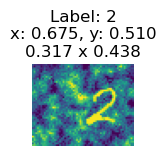

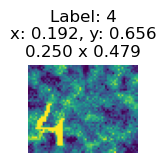

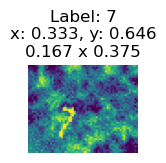

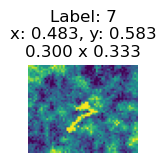

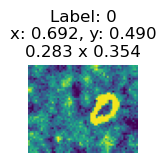

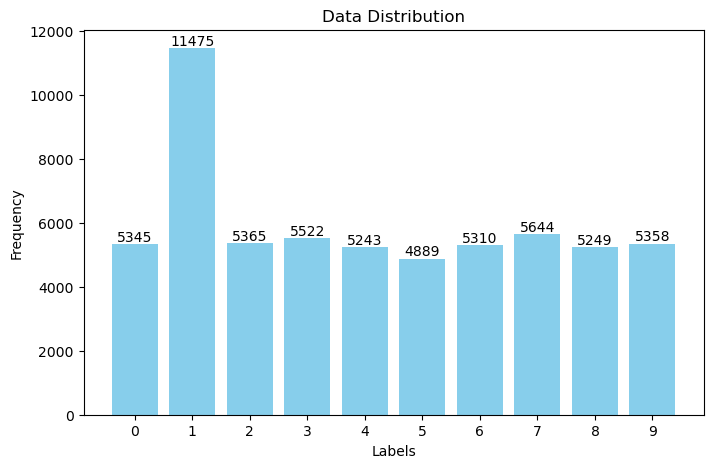

{0.0: 5345,
 1.0: 11475,
 2.0: 5365,
 3.0: 5522,
 4.0: 5243,
 5.0: 4889,
 6.0: 5310,
 7.0: 5644,
 8.0: 5249,
 9.0: 5358}

In [198]:
train_data, val_data, test_data = load_data()

visualize_random_images(train_data, 5)
data_distribution(train_data)
#visualize_images(train_data, 3)

### Normalize Images

In [199]:

def mean_std(data):
    """
    Calculate the mean and standard deviation of the data.
    """
    img, _ = data.tensors
    img = img.float()
    mean = img.mean(dim=(0, 2, 3))
    std = img.std(dim=(0, 2, 3))

    return mean, std


# Lasse sin kode
class LocalizationDataset(Dataset):
    def __init__(self, data, preprocessor=None):
        self.data = data
        self.preprocessor = preprocessor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image, label = self.data[index]
        
        if self.preprocessor:
            image = self.preprocessor(image)
            
        return image, label


In [202]:
mean, std = mean_std(train_data)
preprocessor = transforms.Compose([
        transforms.Normalize(mean, std)
])

# preprocess data
train_data = LocalizationDataset(train_data, preprocessor = preprocessor)
val_data = LocalizationDataset(val_data, preprocessor = preprocessor)
test_data = LocalizationDataset(test_data, preprocessor = preprocessor)

### Training

In [233]:

def train(n_epochs, optimizer, model, loss_func, train_loader):

    n_batch = len(train_loader)
    losses_train = []
    model.train()
    optimizer.zero_grad(set_to_none=True)
    
    
    for epoch in range(1, n_epochs + 1):
        
        loss_train = 0.0
        for imgs, labels in train_loader:

            # We use torch.double to get the same results as Pytorch
            imgs = imgs.to(device=device) 
            labels = labels.to(device=device)

            outputs = model(imgs)
            
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()
            
        losses_train.append(loss_train / n_batch)
        
        print('{}  |  Epoch {}  |  Training loss {:.5f}'.format(
            datetime.now().time(), epoch, loss_train / n_batch))
        
    return losses_train
    


In [ ]:
model = CNN_1(in_channels=1).to(device=device, dtype=torch.double)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
loss_func = localization_loss

train(10, optimizer, model, loss_func, train_loader)

09:31:59.661624  |  Epoch 1  |  Training loss 2.04534
09:33:06.181262  |  Epoch 2  |  Training loss 1.44049
09:34:06.378390  |  Epoch 3  |  Training loss 1.05968
09:35:12.458595  |  Epoch 4  |  Training loss 0.78305
09:36:19.322011  |  Epoch 5  |  Training loss 0.63426
09:37:28.395214  |  Epoch 6  |  Training loss 0.54911
09:38:36.558250  |  Epoch 7  |  Training loss 0.48122
09:39:35.594377  |  Epoch 8  |  Training loss 0.43718
09:40:40.691748  |  Epoch 9  |  Training loss 0.40785
09:41:41.787264  |  Epoch 10  |  Training loss 0.37557


[2.045342060409132,
 1.4404884308409769,
 1.059681387787262,
 0.7830457533139594,
 0.634259051322404,
 0.5491122721564337,
 0.4812208358466546,
 0.43717572944176786,
 0.4078509747198417,
 0.3755669576388014]

### Predictions

In [214]:
# Lasse sin kode:

def unnormalize(image, mean, std):
    #mean = torch.tensor(mean, device=image.device).view(-1, 1, 1)
    #std = torch.tensor(std, device=image.device).view(-1, 1, 1)
    return image * std + mean

def convert_box(box, H, W):
    # Convert normalized [x, y, w, h] (center format) to [x_min, y_min, x_max, y_max] in pixel coordinates
    x, y, w, h = box  
    x_center = x * W 
    y_center = y * H
    box_w = w * W
    box_h = h * H
    x_min = x_center - box_w / 2
    y_min = y_center - box_h / 2
    x_max = x_center + box_w / 2
    y_max = y_center + box_h / 2
    return torch.tensor([x_min, y_min, x_max, y_max], device=box.device)

def visualize_predictions(model, image, label, preprocessor=None, mean=[0.0], std=[1.0], detection_threshold=0.5):
    model.eval()
    device = next(model.parameters()).device

    image_proc = preprocessor(image) if preprocessor else image.clone()
    image_proc = image_proc.unsqueeze(0).to(device, dtype = torch.double)

    with torch.no_grad():
        outputs = model(image_proc)

    pred = outputs[0]
    pred_pc = torch.sigmoid(pred[0]).item()
    pred_box = pred[1:5]
    pred_class = torch.argmax(pred[5:]).item()

    gt_pc = label[0].item()
    gt_box = label[1:5]
    gt_class = int(label[5].item())

    image_disp = unnormalize(image, mean, std)
    image_disp = (image_disp.clamp(0, 1) * 255).to(torch.uint8)
    if image_disp.shape[0] == 1:
        image_disp = image_disp.repeat(3, 1, 1)
    _, H, W = image_disp.shape

    pred_box_pixels = convert_box(pred_box, H, W)
    gt_box_pixels = convert_box(gt_box, H, W)

    # Prepare lists for boxes, colors, and labels for drawing both predicted and ground truth boxes
    boxes = []
    colors = []
    #labels_text = []
    
    if pred_pc > detection_threshold:
        boxes.append(pred_box_pixels)
        colors.append("red")

    
    if gt_pc > 0.5:
        boxes.append(gt_box_pixels)
        colors.append("green")

    
    if boxes:
        boxes = torch.stack(boxes)
        image_with_boxes = draw_bounding_boxes(image_disp, boxes, colors=colors, width=1)
    else:
        image_with_boxes = image_disp

    image_np = image_with_boxes.permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(6, 6))
    plt.imshow(image_np)
    plt.axis("off")
    plt.title("Prediction vs Ground Truth")
    # Create a caption with prediction details and ground truth info
    caption = (f"Prediction: Class {pred_class} (Prob: {pred_pc:.2f}) | "
               f"Ground Truth: Class {gt_class}")
    # Place caption below the image
    plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()

### Model selection and evaluation

In [204]:
def _change_coordinates(bb):
    """
    Change bb from [x, y, w, h] to [x1, y1, x2, y2] (topleft and downright corners)
    """
    x1 = bb[0] - bb[2]/2 # midt - bredde
    y1 = bb[1] - bb[3]/2 # midt - høyde

    x2 = bb[0] + bb[2]/2 # midt + bredde
    y2 = bb[1] + bb[3]/2 # midt + høyde

    return [x1, y1, x2, y2]


In [ ]:
def intersection(bb1, bb2):
    """
    Compute intersection between 2 bb, in global frame of ref
    """
 
    # Change bb from [x, y, w, h] to [x1, y1, x2, y2] (topleft and downright corners)
    b1 = _change_coordinates(bb1)
    b2 = _change_coordinates(bb2)

    # når man har formen [x1, y1, x2, y2]:
    xA = max(b1[0], b2[0]) # finner største x verdi for topleft corner
    yA = max(b1[1], b2[1]) # finner største y verdi for topleft corner
    # (xA, yA) er topleft av intersection 
    
    xB = min(b1[2], b2[2]) # finner minste x verdi for downright corner
    yB = min(b1[3], b2[3]) # finner minste y verdi for downright corner
    # (xB, yB) er downright av intersection 

    area = max(xB-xA, 0) * max(yB-yA, 0)
    return area

   
def IoU(bb1, bb2):
    """
    Compute IoU given 2 bb (local or global)
    """
    intersect = intersection(bb1, bb2)
    union = bb1[-1]*bb1[-2] + bb2[-1]*bb2[-2] - intersect
    IoU = intersect / union
    return IoU
   

# Lasse sin
def compute_IoU_localization(model, loader, preprocessor):
    """
    Compute IoU performance of the model on the given dataset
    """
    model.eval()
    total_iou = 0
    num_samples = 0

    with torch.no_grad():
        for images, labels in loader:
            if preprocessor:
                images = preprocessor(images)
            
            images = images.to(device) #, dtype=torch.double)
            labels = labels.to(device)

            outputs = model(images)

            mask = (labels[:, 0] == 1)
            if mask.sum() == 0:
                continue

            pred_boxes = outputs[mask, 1:5]
            true_boxes = labels[mask, 1:5]

            batch_iou = []
            for i in range(len(true_boxes)):
                iou_value = IoU(pred_boxes[i], true_boxes[i])
                batch_iou.append(iou_value)
            
            total_iou += sum(batch_iou)
            num_samples += len(images)
            
    return total_iou/num_samples
    
   #TODO


# Lasse sin
def compute_accuracy_localization(model, loader, preprocessor):
    """
    Compute accuracy of the model on the given dataset
    """
    model.eval()
    num_correct = 0
    num_samples = 0
        
    with torch.no_grad():
        for images, labels in loader:
            if preprocessor:
                images = preprocessor(images)
            
            images = images.to(device) # ,dtype=torch.double)
            labels = labels.to(device)

            outputs = model(images)
            mask = (labels[:, 0] == 1)
            if mask.sum() == 0:
                continue
            class_probs = torch.softmax(outputs[mask, 5:], dim=1)
            class_pred = torch.argmax(class_probs, dim=1)
            class_true = labels[mask, 5].long()

            num_correct += (class_pred == class_true).sum().item()
            num_samples += mask.sum().item()
    
    return num_correct/num_samples
    

# from performance avsnitt:
""" 
To evaluate how well the model can classify and draw bounding boxes, overall performance can be defined as the mean of the accuracy and the IoU.
The total number of images to classify is the total number of images containing an object (i.e., when the first element pc of y true is 1).
The number of correctly classified images is the number of predictions where both the predicted pc and the predicted label matches their counterparts in y true
"""

def overall_performance(model, loader, preprocessor):
    """
    Compute the overall performance of the model on the given dataset"
    """
    accuracy = compute_accuracy_localization(model, loader, preprocessor)
    IoU = compute_IoU_localization(model, loader, preprocessor)

    print(f"Val Accuracy: {accuracy:.4f}")
    print(f"Val Mean IoU: {IoU:.4f}")
    
    return (accuracy + IoU) / 2

Val Accuracy: 0.1233
Val Mean IoU: 0.0041
Overall performance: 0.0637


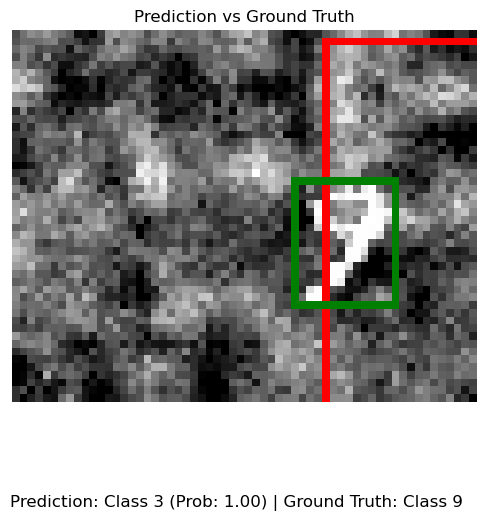

In [218]:
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)
#model.eval()

performance = overall_performance(model, val_loader, preprocessor)
print(f"Overall performance: {performance:.4f}")

# Sample usage:
sample_image, sample_label = val_data[7]
visualize_predictions(model, sample_image, sample_label, preprocessor, mean, std) #mean=[mean.item()], std=[std.item()])

## Model selection and evaluation

In [239]:
# Pipeline for training different models and picking the best one
# based on performance on val data 

#def model_selection()

# Define a list of hyperparameter values to search over
learning_rates = [0.001, 0.0005, 0.0001]
weight_decays = [0, 0.01, 0.001]

# List of model classes to test
models = [CNN_1] #[MyCNN, MyConvOnlyCNN]

best_model = None
best_score = 0
best_hyperparams = {}

# Loop over each model type
for model_class in models:
    # Loop over all combinations of learning rate and weight decay
    for lr, wd in itertools.product(learning_rates, weight_decays):
        print(f"Training {model_class.__name__} with lr={lr}, weight_decay={wd}")
        # Instantiate a new model
        model = model_class()
        
        # Create an optimizer with the current hyperparameters
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        
        # Train the model
        losses = train(
            n_epochs=1,
            optimizer=optimizer,
            model=model,
            loss_func=loss_func,
            train_loader=train_loader)
        
        # Evaluate the model
        model.eval() #har eval både i funksjonen og utfor ?

        #accuracy = compute_accuracy_localization(model, val_loader, preprocessor)
        #mean_iou = compute_IoU_localization(model, val_loader, preprocessor)
        #combined_performance = (accuracy + mean_iou) / 2

        performance = overall_performance(model, val_loader, preprocessor)
        
        print(f"Overall performance: {performance:.4f}")
        
        # Update best model and hyperparameters if performance improved
        if performance > best_score:
            best_score = performance
            best_model = model
            best_hyperparams = {
                'model': model_class.__name__,
                'lr': lr,
                'weight_decay': wd
            }

print("Best hyperparameters:", best_hyperparams)
print("Best overall performance:", best_score)

# Test best model on test data
#test_loader = DataLoader(test_data, batch_size=64, shuffle=False)    
#test_overall_performance = overall_performance(best_model, test_loader, preprocessor)
#print(f"Test overall performance: {test_overall_performance:.4f}")

Training CNN_1 with lr=0.001, weight_decay=0
11:47:52.979224  |  Epoch 1  |  Training loss 2.04525
Val Accuracy: 0.1400
Val Mean IoU: 0.0001
Overall performance: 0.0701
Training CNN_1 with lr=0.001, weight_decay=0.01
11:49:07.942951  |  Epoch 1  |  Training loss 2.14368
Val Accuracy: 0.1003
Val Mean IoU: 0.0000
Overall performance: 0.0502
Training CNN_1 with lr=0.001, weight_decay=0.001
11:50:28.769218  |  Epoch 1  |  Training loss 2.07303
Val Accuracy: 0.1005
Val Mean IoU: 0.0001
Overall performance: 0.0503
Training CNN_1 with lr=0.0005, weight_decay=0
11:51:42.745568  |  Epoch 1  |  Training loss 2.26246
Val Accuracy: 0.1747
Val Mean IoU: 0.0004
Overall performance: 0.0875
Training CNN_1 with lr=0.0005, weight_decay=0.01
11:55:19.971245  |  Epoch 1  |  Training loss 2.31746
Val Accuracy: 0.0963
Val Mean IoU: 0.0005
Overall performance: 0.0484
Training CNN_1 with lr=0.0005, weight_decay=0.001
12:16:52.443451  |  Epoch 1  |  Training loss 2.16426
Val Accuracy: 0.1020
Val Mean IoU: 0.00